In [2]:
import sys
!{sys.executable} -m pip install tensorflow

  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/376.0 MB 10.1 MB/s eta 0:00:38
   ----------------

In [ ]:
import os
import sys
import traci
import csv
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
import traceback
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)

# --- SUMO Configuration ---
try:
    if 'SUMO_HOME' in os.environ:
        tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
        if tools not in sys.path:
            sys.path.append(tools)
        from sumolib import checkBinary, net
        print("SUMO tools imported successfully.")
    else:
        default_sumo_home = os.path.join(os.path.expanduser("~"), "Apps", "SUMO")
        if os.path.exists(default_sumo_home):
            os.environ['SUMO_HOME'] = default_sumo_home
            tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
            if tools not in sys.path:
                 sys.path.append(tools)
            from sumolib import checkBinary, net
            print(f"SUMO_HOME set to default: {default_sumo_home} and tools imported.")
        else:
            print("CRITICAL: SUMO_HOME environment variable is not set and default path not found.")
            print("Please set SUMO_HOME (e.g., os.environ['SUMO_HOME'] = '/usr/share/sumo') or ensure it's in your system PATH.")
except ImportError as e:
    print(f"CRITICAL: Error importing SUMO tools: {e}. Ensure SUMO_HOME is correctly set.")

CONFIG_FILE = "osm.sumocfg"
NET_FILE = "osm.net.xml"
TRAFFIC_LIGHT_ID = 'joinedS_6421159832_cluster_3639980474_3640024452_3640024453_6421159827_#4more_cluster_6421159831_7129012339'
DATA_CSV_FILE = "sumo_data.csv"
MODEL_SAVE_PATH = "offline_dqn_agent.weights.h5"

# DQN Hyperparameters
STATE_FEATURES = 4
NUM_ACTIONS = 4
SEQUENCE_LENGTH = 1
LEARNING_RATE = 0.0005
GAMMA = 0.95
NUM_EPOCHS = 50
BATCH_SIZE = 64
TARGET_NETWORK_UPDATE_FREQ_OFFLINE = 500

# Traffic Light Control Parameters for Evaluation
MIN_GREEN_TIME_EVAL = 10
YELLOW_TIME_EVAL = 6
AGENT_ACTION_TO_SUMO_GREEN_PHASE_EVAL = {0: 0, 1: 2, 2: 4, 3: 6}
SUMO_GREEN_TO_YELLOW_PHASE_EVAL = {0: 1, 2: 3, 4: 5, 6: 7}

# State Definition for Evaluation
APPROACH_EDGES_EVAL = {
    "north": "754598165#2",
    "south": "1053267667#3",
    "east": "749662140#0",
    "west": "885403818#2",
}
VEHICLE_BINS_EVAL = [5, 15, 30]

g_eval_last_total_wait_time = 0

TensorFlow Version: 2.19.0
SUMO tools imported successfully.


In [ ]:
class DQNAgentOffline:
    def __init__(self, state_dims, action_size, sequence_length):
        self.state_feature_size = state_dims
        self.action_size = action_size
        self.sequence_length = sequence_length
        self.gamma = GAMMA
        self.learning_rate = LEARNING_RATE

        self.q_network = self._build_lstm_model()
        self.target_network = self._build_lstm_model()
        self.update_target_network()
        print("Offline DQN Agent Initialized.")
        self.q_network.summary()

    def _build_lstm_model(self):
        model = Sequential([
            Input(shape=(self.sequence_length, self.state_feature_size)),
            LSTM(32, activation='relu', return_sequences=False),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def train_on_batch(self, batch_experiences):
        if not batch_experiences: return 0.0
        current_states_batch_list = []
        next_states_batch_list = []
        for exp_state, _, _, exp_next_state, _ in batch_experiences:
            state_np = np.array(exp_state, dtype=np.float32).reshape(1, self.sequence_length, self.state_feature_size)
            next_state_np = np.array(exp_next_state, dtype=np.float32).reshape(1, self.sequence_length, self.state_feature_size)
            current_states_batch_list.append(state_np[0])
            next_states_batch_list.append(next_state_np[0])
        
        current_states_batch = np.array(current_states_batch_list)
        next_states_batch = np.array(next_states_batch_list)

        q_current_state_batch = self.q_network.predict(current_states_batch, verbose=0)
        q_next_state_target_batch = self.target_network.predict(next_states_batch, verbose=0)

        for i, (state_tuple, action, reward, next_state_tuple, done) in enumerate(batch_experiences):
            target_q_value = reward
            if not done:
                target_q_value += self.gamma * np.amax(q_next_state_target_batch[i])
            action_idx = int(action)
            if 0 <= action_idx < self.action_size:
                 q_current_state_batch[i][action_idx] = target_q_value
        
        history = self.q_network.fit(current_states_batch, q_current_state_batch, batch_size=len(batch_experiences), epochs=1, verbose=0)
        return history.history['loss'][0]

    def load_model(self, filepath):
        try:
            self.q_network.load_weights(filepath)
            self.update_target_network()
            print(f"Model weights loaded from {filepath}")
        except Exception as e: print(f"Error loading model weights: {e}")

    def save_model(self, filepath):
        try:
            self.q_network.save_weights(filepath)
            print(f"Model weights saved to {filepath}")
        except Exception as e: print(f"Error saving model weights: {e}")
    
    def select_action_evaluation(self, current_state):
        q_values = self.q_network.predict(current_state, verbose=0)
        return np.argmax(q_values[0])

In [ ]:
def load_offline_data_from_csv(csv_filepath):
    try:
        df = pd.read_csv(csv_filepath)
    except FileNotFoundError:
        print(f"Error: Data CSV file not found at {csv_filepath}")
        return []
        
    experiences = []
    required_cols = ["state_N", "state_S", "state_E", "state_W", "action", "reward",
                     "next_state_N", "next_state_S", "next_state_E", "next_state_W", "done"]
    if not all(col in df.columns for col in required_cols):
        print(f"Error: CSV missing one or more required columns: {required_cols}")
        return []

    for _, row in df.iterrows():
        try:
            state = (int(row['state_N']), int(row['state_S']), int(row['state_E']), int(row['state_W']))
            action = int(row['action'])
            if not (0 <= action < NUM_ACTIONS): 
                continue
            reward = float(row['reward'])
            next_state = (int(row['next_state_N']), int(row['next_state_S']), int(row['next_state_E']), int(row['next_state_W']))
            done_val = row['done']
            if isinstance(done_val, str): done = done_val.lower() == 'true'
            else: done = bool(done_val)
            experiences.append((state, action, reward, next_state, done))
        except ValueError as e:
            print(f"Warning: Skipping row due to data conversion error: {e}. Row: {row.to_dict()}")
            continue
            
    print(f"Loaded {len(experiences)} valid experiences from {csv_filepath}")
    return experiences

In [ ]:
def train_offline_agent_notebook(total_epochs=NUM_EPOCHS, model_save_path=MODEL_SAVE_PATH, data_csv_path=DATA_CSV_FILE):
    agent = DQNAgentOffline(STATE_FEATURES, NUM_ACTIONS, SEQUENCE_LENGTH)

    experiences_dataset = load_offline_data_from_csv(data_csv_path)
    if not experiences_dataset:
        print("No data to train on. Exiting training.")
        return None, []

    total_batches_trained_ever = 0
    epoch_losses = []

    for epoch in range(total_epochs):
        random.shuffle(experiences_dataset)
        epoch_total_loss = 0.0
        num_batches_this_epoch = 0

        for i in range(0, len(experiences_dataset), BATCH_SIZE):
            batch = experiences_dataset[i:i + BATCH_SIZE]
            if len(batch) < BATCH_SIZE // 2 and epoch < total_epochs - 1 : continue

            loss = agent.train_on_batch(batch)
            epoch_total_loss += loss
            num_batches_this_epoch +=1
            total_batches_trained_ever += 1

            if total_batches_trained_ever % TARGET_NETWORK_UPDATE_FREQ_OFFLINE == 0:
                agent.update_target_network()
        
        avg_epoch_loss = epoch_total_loss / num_batches_this_epoch if num_batches_this_epoch > 0 else 0
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1}/{total_epochs} completed. Avg Batch Loss: {avg_epoch_loss:.6f}")

        if (epoch + 1) % 10 == 0 or epoch == total_epochs -1 :
            agent.save_model(model_save_path)
    
    print(f"Offline training complete. Final model saved to {model_save_path}")
    return agent, epoch_losses

--- Starting Offline DQN Training ---
Offline DQN Agent Initialized.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,868 (19.02 KB)

 Trainable params: 4,868 (19.02 KB)

 Non-trainable params: 0 (0.00 B)

Loaded 333 valid experiences from sumo_data.csv
Epoch 1/50 completed. Avg Batch Loss: 0.137543
Epoch 2/50 completed. Avg Batch Loss: 0.152613
Epoch 3/50 completed. Avg Batch Loss: 0.151415
Epoch 4/50 completed. Avg Batch Loss: 0.142465
Epoch 5/50 completed. Avg Batch Loss: 0.148149
Epoch 6/50 completed. Avg Batch Loss: 0.144857
Epoch 7/50 completed. Avg Batch Loss: 0.144507
Epoch 8/50 completed. Avg Batch Loss: 0.139353
Epoch 9/50 completed. Avg Batch Loss: 0.141323
Epoch 10/50 completed. Avg Batch Loss: 0.131052
Model weights saved to offline_dqn_agent.weights.h5
Epoch 11/50 completed. Avg Batch Loss: 0.139951
Epoch 12/50 completed. Avg Batch Loss: 0.136318
Epoch 13/50 completed. Avg Batch Loss: 0.135171
Epoch 14/50 completed. Avg Batch Loss: 0.132206
Epoch 15/50 completed. Avg Batch Loss: 0.123570
Epoch 16/50 completed. Avg Batch Loss: 0.131826
Epoch 17/50 completed. Avg Batch Loss: 0.129764
Epoch 18/50 completed. Avg Batch Loss: 0.128934
Epoch 19/50 completed. Avg Batch Loss: 0.1266

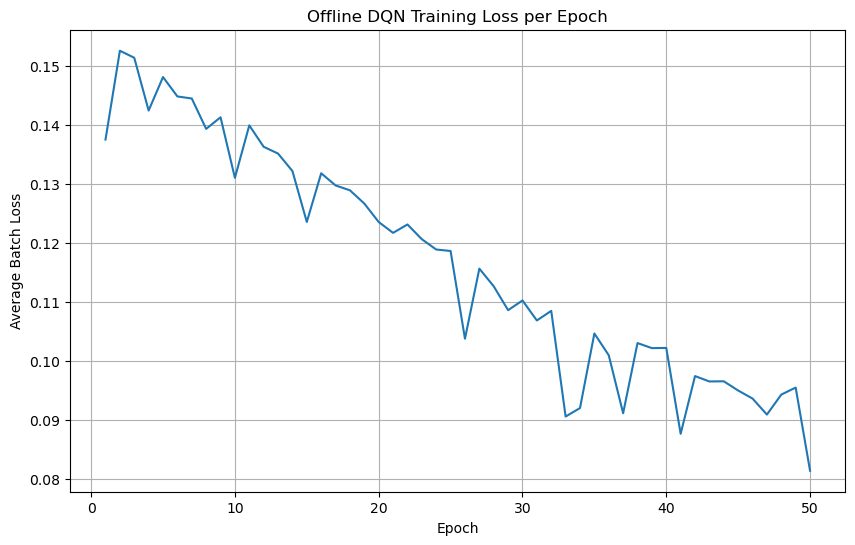

In [ ]:
print("--- Starting Offline DQN Training ---")
trained_agent, training_losses = train_offline_agent_notebook(total_epochs=NUM_EPOCHS, 
                                                              model_save_path=MODEL_SAVE_PATH,
                                                              data_csv_path=DATA_CSV_FILE)

# Plot training loss
if training_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(training_losses) + 1), training_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Average Batch Loss")
    plt.title("Offline DQN Training Loss per Epoch")
    plt.grid(True)
    plt.show()
else:
    print("No training losses to plot (training might have failed or no data).")